Make sure you have installed `boto3`

SysAdmin task: attach `AmazonRekognitionFullAccess` to role `role-cdas-itam-projects`

In [28]:
#!pip install -q boto3
#!pip install -q pillow #for PIL

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Take me to [clases](#clases)

#### <a name="regreso"></a>regreso

# 1. Upload `train` and `test` dirs under `s3` bucket `rekognition-fauna-empty`.

In [29]:
import os
import glob
import itertools
import pathlib
import datetime

import boto3

The path in `s3` bucket will be created using the date of execution of next cells.

In [30]:
date_today = datetime.date.today().strftime("%d-%m-%Y")

In [31]:
#set_s3_bucket
bucket_for_train_and_test_datasets = "kemitl-2021-cdas-project-rekognition"

# create destiny directory
destiny_dir = os.path.join(bucket_for_train_and_test_datasets,date_today)
# create input directory
input_directory = "/shared_volume/rekognition/"

#create test and train directories
train = os.path.join(input_directory,
                     "train")
test  = os.path.join(input_directory,
                    "test")
# set files extensions
patterns = ["jpeg","jpg"]

# create test and train paths and keys dictionaries
dict_train_with_classes_paths_and_keys_in_s3 = {}
dict_test_with_classes_paths_and_keys_in_s3 = {}

For this step dirs `train` and `test` need to exist in `/shared_volume` directory.

In [32]:
os.makedirs(input_directory, exist_ok=True)
os.makedirs(train,exist_ok=True)
os.makedirs(test,exist_ok=True)

In [33]:
def multiple_file_types(input_directory, patterns, recursive=False):
    """
    Return iterable with files that have a common pattern. Will search
    in a recursive or non recursive way.
    Args:
        input_directory (str): directory where files with common pattern
        will be searched.
        patterns (list): list of patterns to search for.
    Returns:
        iterable with files that have a common pattern.
    """
    if recursive:
        expression = "/**/*"
    else:
        expression = "/*"
    return itertools.chain.from_iterable(glob.iglob(input_directory + \
                                                    expression + pattern,
                                                    recursive=recursive) for pattern in patterns)

Next cells will upload to s3 and save urls where were uploaded in `dict_train_with_classes_paths_and_keys_in_s3` and `dict_test_with_classes_paths_and_keys_in_s3` lists

Include `rekognition-fauna-empty` bucket to policy `cdas-itam-buckets-projects`

In [34]:
s3 = boto3.client('s3')
iterator = multiple_file_types(input_directory, patterns, recursive=True)
for file_img in iterator:
    print("file: %s" % file_img)
    file_img_pathlib = pathlib.Path(file_img)
    name_of_class = file_img_pathlib.parent.name
    upload = False
    if not name_of_class in dict_train_with_classes_paths_and_keys_in_s3 and "train" in file_img:
        dict_train_with_classes_paths_and_keys_in_s3[name_of_class] = {}
    if not name_of_class in dict_test_with_classes_paths_and_keys_in_s3 and "test" in file_img:
        dict_test_with_classes_paths_and_keys_in_s3[name_of_class] = {}
    if "train" in file_img:
        dst_file = os.path.join(date_today,
                                "train",
                                 name_of_class,
                                 file_img_pathlib.name)
        s3_dst_file = os.path.join("s3://",
                                   bucket_for_train_and_test_datasets,
                                   dst_file)
        dict_train_with_classes_paths_and_keys_in_s3[name_of_class][s3_dst_file] = dst_file
        upload=True
    else:
        if "test" in file_img:
            dst_file = os.path.join(date_today,
                                    "test",
                                     name_of_class,
                                     file_img_pathlib.name)
            s3_dst_file = os.path.join("s3://",
                                       bucket_for_train_and_test_datasets,
                                       dst_file)
            dict_test_with_classes_paths_and_keys_in_s3[name_of_class][s3_dst_file] = dst_file
            upload=True
    if upload:
        print("will be uploaded in bucket %s to: %s" % (bucket_for_train_and_test_datasets,dst_file))
        print("uploading...")
        s3.upload_file(file_img, bucket_for_train_and_test_datasets, dst_file)
    else:
        print("will not be uploaded")

file: /shared_volume/rekognition/test/Amuzgo/Amuzgotelar19.jpeg
will be uploaded in bucket kemitl-2021-cdas-project-rekognition to: 20-03-2022/test/Amuzgo/Amuzgotelar19.jpeg
uploading...
file: /shared_volume/rekognition/test/Amuzgo/Amuzgotextil16.jpeg
will be uploaded in bucket kemitl-2021-cdas-project-rekognition to: 20-03-2022/test/Amuzgo/Amuzgotextil16.jpeg
uploading...
file: /shared_volume/rekognition/test/Amuzgo/Amuzgotelar13.jpeg
will be uploaded in bucket kemitl-2021-cdas-project-rekognition to: 20-03-2022/test/Amuzgo/Amuzgotelar13.jpeg
uploading...
file: /shared_volume/rekognition/test/Amuzgo/Amuzgotextil3.jpeg
will be uploaded in bucket kemitl-2021-cdas-project-rekognition to: 20-03-2022/test/Amuzgo/Amuzgotextil3.jpeg
uploading...
file: /shared_volume/rekognition/test/Amuzgo/Amuzgotelar14.jpeg
will be uploaded in bucket kemitl-2021-cdas-project-rekognition to: 20-03-2022/test/Amuzgo/Amuzgotelar14.jpeg
uploading...
file: /shared_volume/rekognition/test/Amuzgo/Amuzgotextil13.jpe

In [35]:
# create s3 resource object
s3 = boto3.resource('s3')

# create s3 bucket
s3_bucket = s3.Bucket(bucket_for_train_and_test_datasets)

for name_of_class in dict_train_with_classes_paths_and_keys_in_s3:
    for path_in_s3 in dict_train_with_classes_paths_and_keys_in_s3[name_of_class]:
        key_in_s3 = dict_train_with_classes_paths_and_keys_in_s3[name_of_class][path_in_s3]
        objs = list(s3_bucket.objects.filter(Prefix=key_in_s3))
        if(len(objs)>0):
            print("key exists!!")
        else:
            print("key doesn't exist!")

key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!


In [36]:
# create s3 resource object
s3 = boto3.resource('s3')

# create s3 bucket
s3_bucket = s3.Bucket(bucket_for_train_and_test_datasets)

for name_of_class in dict_test_with_classes_paths_and_keys_in_s3:
    for path_in_s3 in dict_test_with_classes_paths_and_keys_in_s3[name_of_class]:
        key_in_s3 = dict_test_with_classes_paths_and_keys_in_s3[name_of_class][path_in_s3]
        objs = list(s3_bucket.objects.filter(Prefix=key_in_s3))
        if(len(objs)>0):
            print("key exists!!")
        else:
            print("key doesn't exist!")

key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!
key exists!!


# 2. Create train and test manifests

In [37]:
import json

In [38]:
def create_manifest(type_of_manifest,
                    d_with_classes_paths_and_keys_in_s3):
    d_now = datetime.datetime.now().isoformat()
    d_now = d_now[0:len(d_now)-3] #just 3 decimals
    counter = 0
    name_manifest = "".join([type_of_manifest,
                             ".manifest"])
    with open(name_manifest, "w+") as dst:
        for name_of_class in d_with_classes_paths_and_keys_in_s3:
            for path_in_s3 in d_with_classes_paths_and_keys_in_s3[name_of_class].keys():
                d_aux = {"confidence": 1,
                         "class-name": name_of_class,
                         "human-annotated": "yes",
                         "creation-date": d_now,
                         "type": "groundtruth/image-classification"
                        }
                name_dataset = "".join([type_of_manifest,
                                        "dataset-classification_",
                                        name_of_class])
                name_metadata = "".join([name_dataset,
                                         "-metadata"])
                d_manifest = {"source-ref": path_in_s3,
                              name_dataset: counter,
                              name_metadata: d_aux
                              }
                json.dump(d_manifest, dst)
                dst.write("\n")
            counter += 1
    return name_manifest

In [39]:
name_manifest_train = create_manifest("train",
                                      dict_train_with_classes_paths_and_keys_in_s3)

In [40]:
name_manifest_train

'train.manifest'

In [41]:
name_manifest_test = create_manifest("test",
                                     dict_test_with_classes_paths_and_keys_in_s3)

In [42]:
name_manifest_test

'test.manifest'

In [43]:
# create destiny path for train and test manifests
dst_manifest_train = os.path.join(date_today,
                                  name_manifest_train)
dst_manifest_test = os.path.join(date_today,
                                 name_manifest_test)
# set s3 client
s3 = boto3.client('s3')

#upload manifest for training
s3.upload_file(name_manifest_train, bucket_for_train_and_test_datasets, dst_manifest_train)

#upload manifest for testing
s3.upload_file(name_manifest_test, bucket_for_train_and_test_datasets, dst_manifest_test)

In [44]:
dst_manifest_train

'20-03-2022/train.manifest'

In [45]:
dst_manifest_test

'20-03-2022/test.manifest'

# Save Manifest files

In [59]:
d_now = datetime.datetime.now().isoformat()
d_now = d_now[0:len(d_now)-3] #just 3 decimals
file_name = "manifest_variables"
file = "".join([file_name,".json"])
with open(file, "w+") as dst:
    d_aux = {
        "creation-date": d_now,
        "dst_manifest_train": dst_manifest_train,
        "dst_manifest_test": dst_manifest_test,
            }
    json.dump(d_aux, dst)
    dst.write("\n")

## show some training pictures

In [46]:
iterator = multiple_file_types(input_directory, patterns, recursive=True)
save_imgs_paths = []
for img_path in iterator:
    save_imgs_paths.append(img_path)

In [50]:
!pip install matplotlib

     |████████████████████████████████| 11.3 MB 26.7 MB/s            
     |████████████████████████████████| 899 kB 114.2 MB/s            
     |████████████████████████████████| 1.2 MB 105.4 MB/s            
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## <a name="clases"></a>Clases

In [53]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont, Image

### Amuzgo

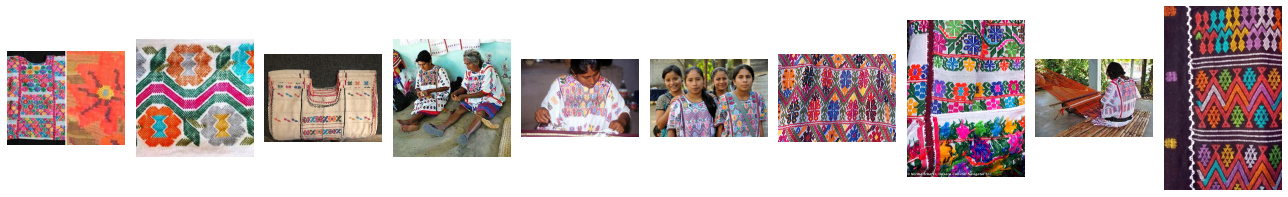

In [54]:
fig, axes = plt.subplots(1, 10, figsize=(18, 5))
axes = axes.flatten()
for ind, (image_path, ax) in enumerate(zip(save_imgs_paths[:10], axes)):
  images=Image.open(image_path)
  ax.imshow(images)
  ax.axis('off')
plt.tight_layout()
plt.show()

### Awakateko

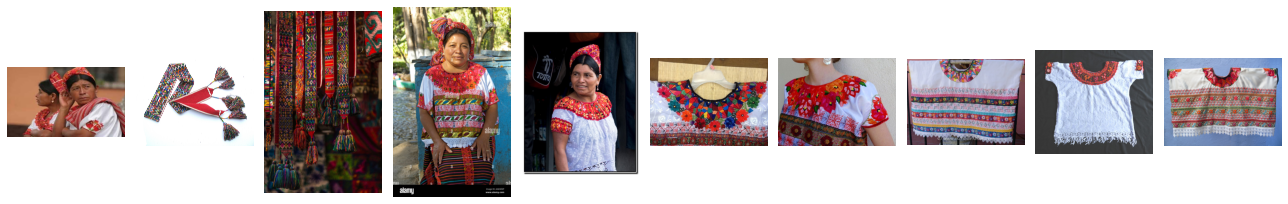

In [67]:
fig, axes = plt.subplots(1, 10, figsize=(18, 5))
axes = axes.flatten()
for ind, (image_path, ax) in enumerate(zip(save_imgs_paths[51:61], axes)):
  images=Image.open(image_path)
  ax.imshow(images)
  ax.axis('off')
plt.tight_layout()
plt.show()

Take me to [regreso](#regreso)